In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [14]:
from env import PortfolioEnv

In [15]:
PROCESSED_DIR = "../data/processed"
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]
RETURNS = f"{PROCESSED_DIR}/returns_matrix.csv"
if not os.path.exists(RETURNS):
    raise FileNotFoundError(f"returns_matrix.csv not found at {RETURNS}")

returns_df = pd.read_csv(RETURNS, parse_dates=["Date"])
returns_df = returns_df.set_index("Date")
print("Loaded returns data:", returns_df.shape)
print(returns_df.head())

Loaded returns data: (2244, 5)
                AAPL      MSFT      AMZN     GOOGL      META
Date                                                        
2015-02-02  0.012251  0.021443  0.027651 -0.010001 -0.012194
2015-02-03  0.000189  0.007717 -0.002527  0.002065  0.005453
2015-02-04  0.007516  0.005750  0.003295 -0.013593  0.003046
2015-02-05  0.007303  0.014466  0.024749  0.007060 -0.000264
2015-02-06 -0.008714 -0.000908  0.001043  0.007620 -0.015192


In [16]:
# Chronological split matching MDP and Q-Learning
idx = returns_df.index
split = int(0.8 * len(idx))
train_idx = idx[:split]
test_idx  = idx[split:]
returns_test = returns_df.loc[test_idx]
print("Baselines test window:", returns_test.shape)

Baselines test window: (449, 5)


In [17]:
def sharpe_ratio(daily_returns, risk_free_daily=0.00002):
    excess = daily_returns - risk_free_daily
    mu = excess.mean()
    sigma = excess.std()
    daily = mu / (sigma + 1e-9)
    return daily * np.sqrt(252)

def plot_cumulative_returns(daily_returns, title="Cumulative Return"):
    cum = (1 + daily_returns)
    cum = cum.cumprod()
    plt.plot(cum)
    plt.title(title)
    plt.xlabel("Time (days)")
    plt.ylabel("Cumulative growth of $1")
    plt.grid(True)
    plt.show()

Baseline policy: buy and hold

In [18]:
def run_buy_and_hold_equal(env: PortfolioEnv):
    state = env.reset()
    rewards = []
    values = [env.value]

    # Constant equal weights
    w = state["weights"]

    while True:
        next_state, reward, done, info = env.step(w)
        rewards.append(reward)
        values.append(info["portfolio_value"])
        if done:
            break

    rewards = np.array(rewards)
    values = np.array(values)
    return rewards, values

Buy-and-Hold Equal Weights Sharpe: 0.345
Final portfolio value: 1.121


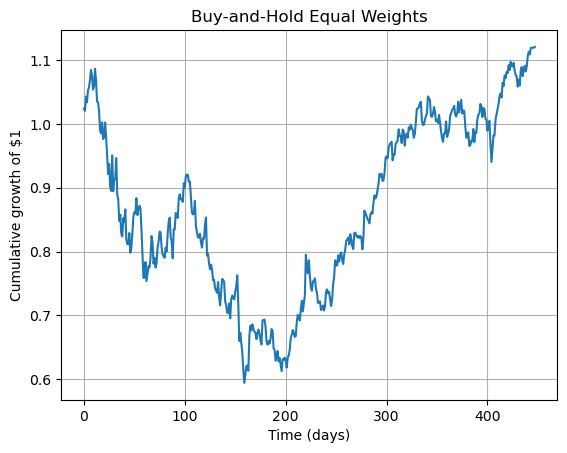

In [19]:
env = PortfolioEnv(returns_test, transaction_cost=0.001, initial_value=1.0)

bh_rewards, bh_values = run_buy_and_hold_equal(env)
print(f"Buy-and-Hold Equal Weights Sharpe: {sharpe_ratio(bh_rewards):.3f}")
print(f"Final portfolio value: {bh_values[-1]:.3f}")

plot_cumulative_returns(bh_rewards, title="Buy-and-Hold Equal Weights")

Buy-and-Hold Equal Weights Sharpe: 0.815
Final portfolio value: 5.149


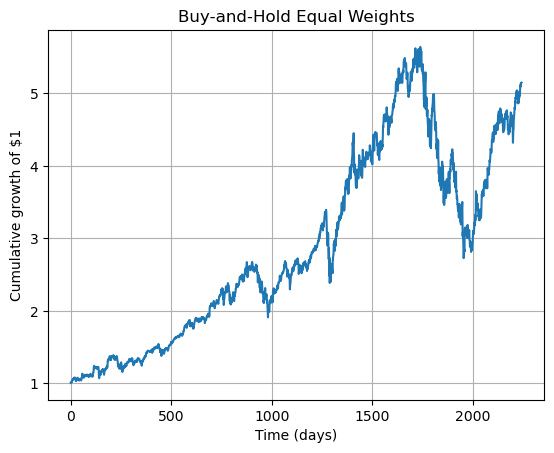

In [20]:
env = PortfolioEnv(returns_df, transaction_cost=0.001, initial_value=1.0)

bh_rewards, bh_values = run_buy_and_hold_equal(env)
print(f"Buy-and-Hold Equal Weights Sharpe: {sharpe_ratio(bh_rewards):.3f}")
print(f"Final portfolio value: {bh_values[-1]:.3f}")

plot_cumulative_returns(bh_rewards, title="Buy-and-Hold Equal Weights")

Baseline policy: daily random

In [21]:
def run_random_policy(env: PortfolioEnv):
    state = env.reset()
    rewards = []
    values = [env.value]

    while True:
        # Random weights sampled from Dirichlet distribution
        w = np.random.dirichlet(np.ones(env.n_assets))

        next_state, reward, done, info = env.step(w)
        rewards.append(reward)
        values.append(info["portfolio_value"])

        if done:
            break

    return np.array(rewards), np.array(values)

Random Policy Sharpe: -0.128
Final portfolio value: 0.852


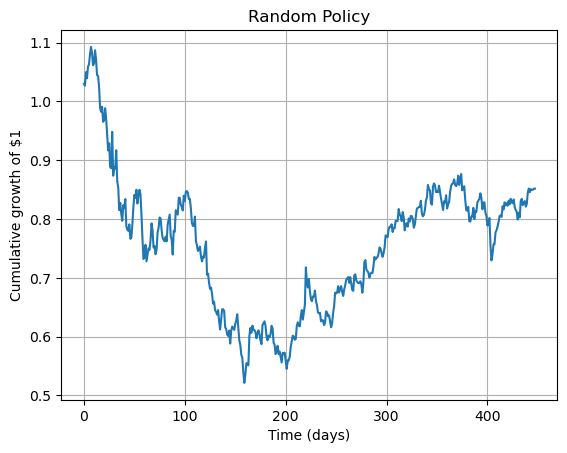

In [22]:
env = PortfolioEnv(returns_test, transaction_cost=0.001, initial_value=1.0)

rand_rewards, rand_values = run_random_policy(env)
print(f"Random Policy Sharpe: {sharpe_ratio(rand_rewards):.3f}")
print(f"Final portfolio value: {rand_values[-1]:.3f}")

plot_cumulative_returns(rand_rewards, title="Random Policy")

Random Policy Sharpe: 0.014
Final portfolio value: 0.775


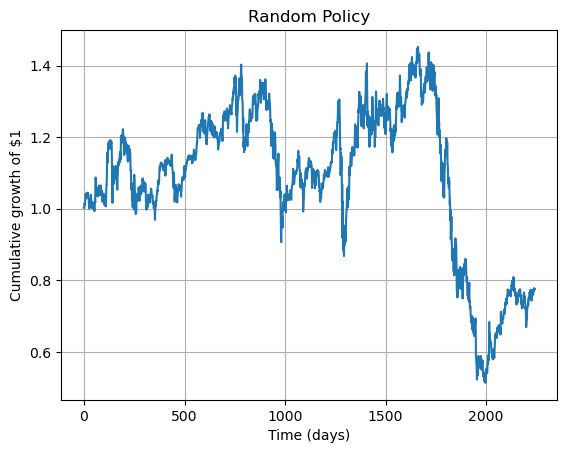

In [23]:
env = PortfolioEnv(returns_df, transaction_cost=0.001, initial_value=1.0)

rand_rewards, rand_values = run_random_policy(env)
print(f"Random Policy Sharpe: {sharpe_ratio(rand_rewards):.3f}")
print(f"Final portfolio value: {rand_values[-1]:.3f}")

plot_cumulative_returns(rand_rewards, title="Random Policy")

Baseline: monthly rebalance to equal

In [24]:
def run_monthly_rebalance(env: PortfolioEnv, rebalance_every=21):
    state = env.reset()
    rewards = []
    values = [env.value]

    equal_w = np.ones(env.n_assets) / env.n_assets
    current_w = equal_w.copy()
    day = 0

    while True:
        # Apply one day of returns to simulate weight drift
        asset_returns = env.returns.iloc[day].values
        current_w = current_w * (1 + asset_returns)
        current_w = current_w / current_w.sum()

        # Rebalance every 21 days
        if day % rebalance_every == 0:
            w = equal_w
        else:
            w = current_w

        next_state, reward, done, info = env.step(w)
        rewards.append(reward)
        values.append(info["portfolio_value"])
        day += 1

        if done:
            break

    return np.array(rewards), np.array(values)

Monthly Rebalance Sharpe: 0.424
Final portfolio value: 1.170


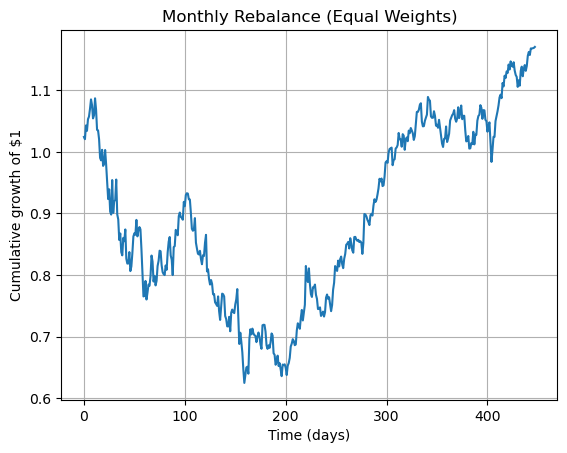

In [25]:
env = PortfolioEnv(returns_test, transaction_cost=0.001, initial_value=1.0)

mr_rewards, mr_values = run_monthly_rebalance(env)

print(f"Monthly Rebalance Sharpe: {sharpe_ratio(mr_rewards):.3f}")
print(f"Final portfolio value: {mr_values[-1]:.3f}")

plot_cumulative_returns(mr_rewards, title="Monthly Rebalance (Equal Weights)")

Monthly Rebalance Sharpe: 0.872
Final portfolio value: 5.773


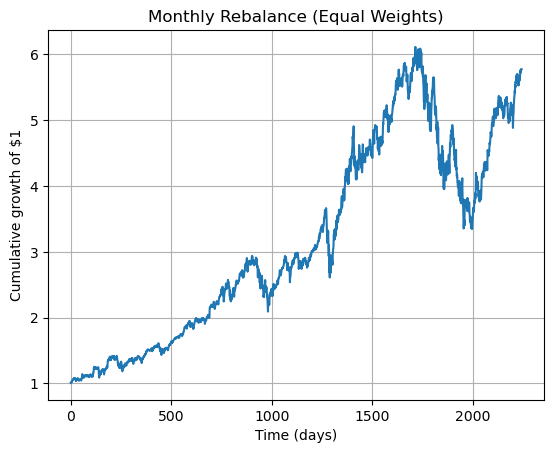

In [26]:
env = PortfolioEnv(returns_df, transaction_cost=0.001, initial_value=1.0)

mr_rewards, mr_values = run_monthly_rebalance(env)

print(f"Monthly Rebalance Sharpe: {sharpe_ratio(mr_rewards):.3f}")
print(f"Final portfolio value: {mr_values[-1]:.3f}")

plot_cumulative_returns(mr_rewards, title="Monthly Rebalance (Equal Weights)")